In [1]:
import numpy as np                                             # dense matrices
import pandas as pd                                            # see below for install instruction
import json
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.metrics.pairwise import pairwise_distances        # pairwise distances
from copy import copy                                          # deep copies
import matplotlib.pyplot as plt                                # plotting
%matplotlib inline

'''compute norm of a sparse vector
   Thanks to: Jaiyam Sharma'''
def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return(norm)

In [2]:
wiki = pd.read_csv('people_wiki.csv')

In [3]:
wiki.head(2)

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...


In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)
    
corpus = load_sparse_csr('people_wiki_tf_idf.npz')

In [5]:
with open('people_wiki_map_index_to_word.json') as people_wiki_map_index_to_word:    
    map_index_to_word = json.load(people_wiki_map_index_to_word)

In [6]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

In [7]:
# Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
np.random.seed(0) # set seed=0 for consistent results
print(generate_random_vectors(num_vector=3, dim=5))

[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323]]


In [8]:
# Generate 16 random vectors of dimension 547979
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
print(random_vectors.shape)

(547979, 16)


In [9]:
doc = corpus[0, :] # vector of tf-idf values for document 0
print(doc.dot(random_vectors[:, 0]) >= 0) # True if positive sign; False if negative sign

[ True]


In [10]:
print(doc.dot(random_vectors[:, 1]) >= 0)

[ True]


In [11]:
print(doc.dot(random_vectors) >= 0) # should return an array of 16 True/False bits
print(np.array(doc.dot(random_vectors) >= 0, dtype=int)) # display index bits in 0/1's

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[[1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1]]


In [12]:
print(corpus[0:2].dot(random_vectors) >= 0) # compute bit indices of first two documents
print(corpus.dot(random_vectors) >= 0) # compute bit indices of ALL documents

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]
 [ True False False False  True  True False  True  True False  True False
   True False False  True]]
[[ True  True False ...  True False  True]
 [ True False False ... False False  True]
 [False  True False ...  True False  True]
 ...
 [ True  True False ...  True  True  True]
 [False  True  True ...  True False  True]
 [ True False  True ... False False  True]]


In [13]:
doc = corpus[0, :]  # first document
index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print(index_bits)
print(powers_of_two)           # [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
print(index_bits.dot(powers_of_two))

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50917]


In [14]:
index_bits = corpus.dot(random_vectors) >= 0
print(index_bits.dot(powers_of_two))
print(len(index_bits.dot(powers_of_two)))

[50917 36265 19365 ... 52983 27589 41449]
59071


In [15]:
def train_lsh(data, num_vector=16, seed=None):
    
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            # If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] =  [data_index]
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        else:
            table[bin_index].append(data_index)
            

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

In [16]:
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print('Passed!')
else:
    print('Check your code.')

Passed!


In [20]:
print(wiki[wiki['name'] == 'Barack Obama'])

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text  
35817  barack hussein obama ii brk husen bm born augu...  


In [23]:
wiki[wiki['name'] == 'Barack Obama'].index[0]

35817

In [36]:
index_bits_BO = corpus[wiki[wiki['name'] == 'Barack Obama'].index[0], :].dot(random_vectors) >= 0
print(index_bits_BO%2)
print(index_bits_BO.dot(powers_of_two))

[[0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0]]
[29090]


In [40]:
print(np.array(model['bin_index_bits'][35817], dtype=int)) # list of 0/1's

[1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0]


In [41]:
wiki[wiki['name'] == 'Joe Biden'].index[0]

24478

In [42]:
index_bits_JB = corpus[wiki[wiki['name'] == 'Joe Biden'].index[0], :].dot(random_vectors) >= 0
print(index_bits_JB%2)
print(index_bits_JB.dot(powers_of_two))

[[0 0 1 0 1 1 0 1 0 1 1 0 0 0 1 1]]
[11619]


In [43]:
print(np.array(model['bin_index_bits'][24478], dtype=int)) # list of 0/1's

[1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]


In [44]:
contador = 0
for i, j in zip(np.array(model['bin_index_bits'][35817], dtype=int), np.array(model['bin_index_bits'][24478], dtype=int)):
    if i == j:
        contador += 1
contador

14

In [33]:
print(wiki[wiki['name']=='Wynn Normington Hugh-Jones'])

print(np.array(model['bin_index_bits'][22745], dtype=int)) # list of 0/1's
print(np.sum(np.array(model['bin_index_bits'][35817] == model['bin_index_bits'][22745])))

                                                     URI  \
22745  <http://dbpedia.org/resource/Wynn_Normington_H...   

                             name  \
22745  Wynn Normington Hugh-Jones   

                                                    text  
22745  sir wynn normington hughjones kb sometimes kno...  
[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]
8


In [34]:
print(model['table'][model['bin_indices'][35817]])

[21426, 35817, 39426, 50261, 53937]


In [35]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama

wiki.loc[doc_ids] # filter by id column

#It turns out that Joe Biden is much closer to Barack Obama than any of the four documents, even though Biden's bin representation differs from Obama's by 2 bits.

,URI,name,text
21426,<http://dbpedia.org/resource/Mark_Boulware>,Mark Boulware,mark boulware born 1948 is an american diploma...
39426,<http://dbpedia.org/resource/John_Wells_(polit...,John Wells (politician),sir john julius wells born 30 march 1925 is a ...
50261,<http://dbpedia.org/resource/Francis_Longstaff>,Francis Longstaff,francis a longstaff born august 3 1956 is an a...
53937,<http://dbpedia.org/resource/Madurai_T._Sriniv...,Madurai T. Srinivasan,maduraitsrinivasan is a wellknown figure in th...


In [45]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print('================= Cosine distance from Barack Obama')
print('Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf)))
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print('Barack Obama - {0:24s}: {1:f}'.format(wiki.iloc[doc_id]['name'],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf)))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


In [46]:
from itertools import combinations

num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius):
    print(diff)

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

In [47]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = (alternate_bits[i] + 1)%2 # YOUR CODE HERE 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin]) # YOUR CODE HERE: Update candidate_set with the documents in this bin.
            
    return candidate_set

In [48]:
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print('Passed test')
else:
    print('Check your code')
print('List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261')

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


In [49]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print('Passed test')
else:
    print ('Check your code')

Passed test


In [53]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = pd.DataFrame(index=candidate_set)
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(by=['distance'], ascending=True)[:k], len(candidate_set)

In [56]:
print (query(corpus[35817,:], model, k=10, max_search_radius=3))

(       distance
35817  0.000000
24478  0.703139
56008  0.856848
37199  0.874669
40353  0.890034
9267   0.898377
55909  0.899340
9165   0.900921
57958  0.903003
49872  0.909533, 727)


In [58]:
result, num_candidates_considered = query(corpus[35817,:], model, k=10, max_search_radius=3)
print (result.join(wiki).sort_values(by='distance')[['distance', 'name']])

       distance                     name
35817  0.000000             Barack Obama
24478  0.703139                Joe Biden
56008  0.856848            Nathan Cullen
37199  0.874669  Barry Sullivan (lawyer)
40353  0.890034            Neil MacBride
9267   0.898377      Vikramaditya Khanna
55909  0.899340              Herman Cain
9165   0.900921     Raymond F. Clevenger
57958  0.903003        Michael J. Malbin
49872  0.909533            Lowell Barron


In [68]:
import time

num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time
    
    print ('Radius:', max_search_radius)
    # Display 10 nearest neighbors, along with document ID and name
    print (result.join(wiki).sort_values(by='distance')[['distance', 'name']])
    
    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)
    
    print(result['distance'].iloc[1:].mean())

Radius: 0
       distance                     name
35817  0.000000             Barack Obama
21426  0.950867            Mark Boulware
39426  0.975966  John Wells (politician)
50261  0.978256        Francis Longstaff
53937  0.993092    Madurai T. Srinivasan
0.9745452682750878
Radius: 1
       distance                                   name
35817  0.000000                           Barack Obama
41631  0.947459                            Binayak Sen
21426  0.950867                          Mark Boulware
33243  0.951766                        Janice Lachance
33996  0.960859                            Rufus Black
28444  0.961081                       John Paul Phelan
20347  0.974130                        Gianni De Fraja
39426  0.975966                John Wells (politician)
34547  0.978215  Nathan Murphy (Australian politician)
50261  0.978256                      Francis Longstaff
0.9642887060258674
Radius: 2
       distance                 name
35817  0.000000         Barack Obama
24478  

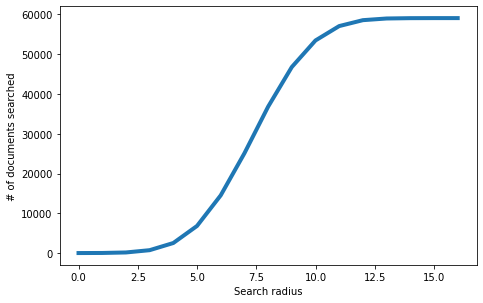

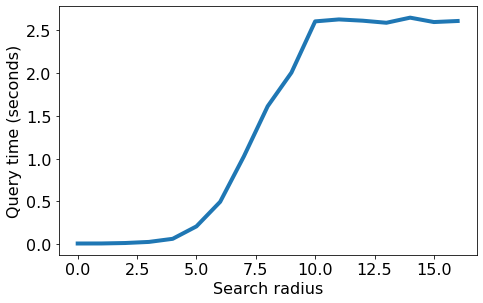

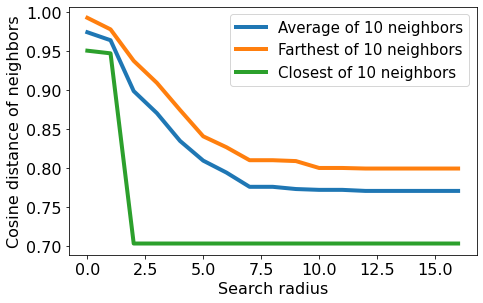

In [61]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [62]:
print('Radius 2 -> Joe Biden')

Radius 2 -> Joe Biden


In [69]:
print('Radius 7 -> avg <= 0.78')

Radius 7 -> avg <= 0.78


In [73]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = pd.DataFrame(index=range(num_data_points))
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(by=['distance'], ascending=True)[:k]

In [74]:
max_radius = 17
precision = {i:[] for i in range(max_radius)}
average_distance  = {i:[] for i in range(max_radius)}
query_time  = {i:[] for i in range(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25).index.values)
    # Get the set of 25 true nearest neighbors
    
    for r in range(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result.index.values) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


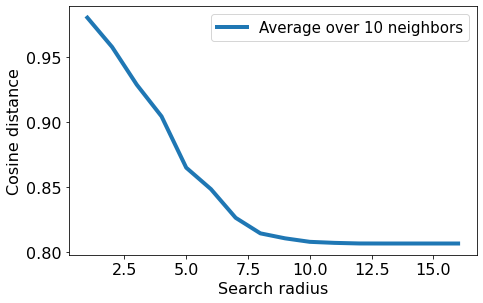

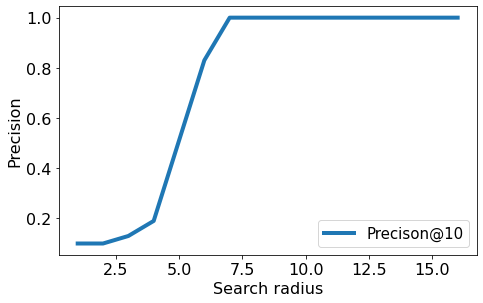

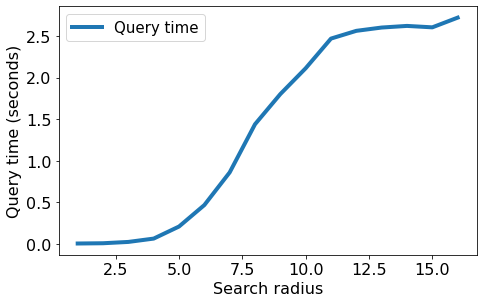

In [76]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in range(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in range(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in range(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [77]:
precision = {i:[] for i in range(5,20)}
average_distance  = {i:[] for i in range(5,20)}
query_time = {i:[] for i in range(5,20)}
num_candidates_history = {i:[] for i in range(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25).index.values)
    # Get the set of 25 true nearest neighbors

for num_vector in range(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result.index.values) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


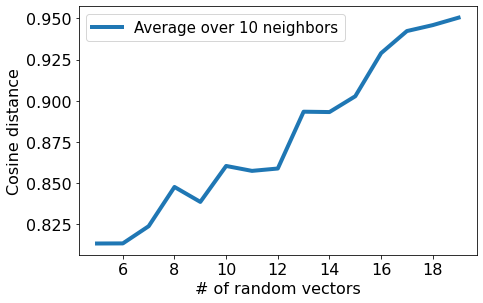

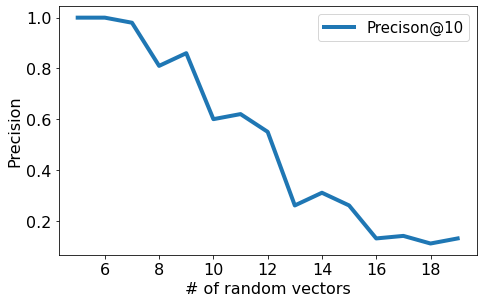

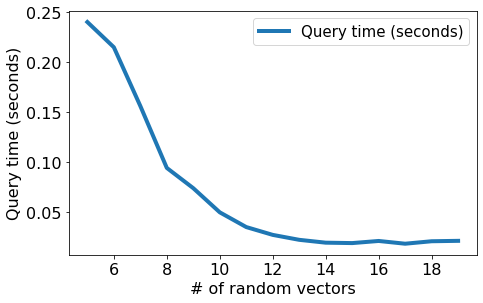

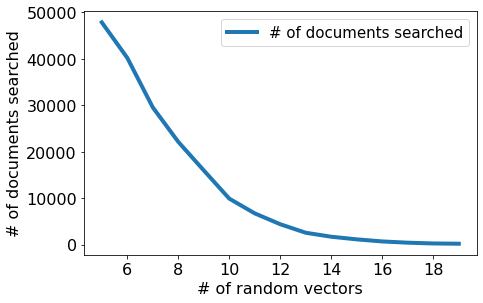

In [79]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in range(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in range(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in range(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in range(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()